In [1]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster('local').setAppName('spark_sql_basic')
sc = SparkContext(conf = conf)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/12 12:01:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/12 12:01:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# RDD만을 이용한 데이터 추출

In [2]:
movies_rdd = sc.parallelize([
    (1, ("어벤져스", "마블")),
    (2, ("슈퍼맨", "DC")),
    (3, ("배트맨", "DC")),
    (4, ("겨울왕국", "디즈니")),
    (5, ("아이언맨", "마블"))
])


attendances_rdd = sc.parallelize([
    (1, (13934592, "KR")),
    (2, (2182227,"KR")),
    (3, (4226242, "KR")),
    (4, (10303058, "KR")),
    (5, (4300365, "KR"))
])

마블 영화 중 관객 수가 500만 이상인 영화 가져오기
1. Inner Join -> Filter By Movies -> Filter By attendance
2. Filter By Movies, Attendance -> Inner Join (the better)

In [3]:
# Case 1. Join먼저 -> filter 나중에

movie_att = movies_rdd.join(attendances_rdd)
movie_att.collect()

[(2, (('슈퍼맨', 'DC'), (2182227, 'KR'))),
 (4, (('겨울왕국', '디즈니'), (10303058, 'KR'))),
 (1, (('어벤져스', '마블'), (13934592, 'KR'))),
 (3, (('배트맨', 'DC'), (4226242, 'KR'))),
 (5, (('아이언맨', '마블'), (4300365, 'KR')))]

In [4]:
movie_att.filter(lambda x: x[1][0][1] == '마블' and x[1][1][0]>=5000000).collect()

[(1, (('어벤져스', '마블'), (13934592, 'KR')))]

In [5]:
# Case 2. Filter먼저 -> join나중에


filtered_movies = movies_rdd.filter(lambda x:x[1][1]=='마블')
filtered_att= attendances_rdd.filter(lambda x:x[1][0]>=5000000)
filtered_movies.join(filtered_att).collect()

[(1, (('어벤져스', '마블'), (13934592, 'KR')))]

# Spark SQL 사용하기

In [1]:
%pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 310.8/310.8 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 200.5/200.5 kB 12.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285411 sha256=6dde6522add9bb76503f5d693af8e4b06a51ca5987761dd5bf8c289b2ab3f7f9
  Stored in directory: c:\users\temp\appdata\local\pip\cache\wheels\2b\9a\39\d8019ffbfb76a39433455e3d5799e94d3e3cae8f41229f6bf8
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [6]:
from pyspark.sql import SparkSession

# spark session 생성
spark = SparkSession.builder.master('local').appName('spark-sql').getOrCreate()
spark

**RDD를 이용해서 데이터 프레임 생성하기**

In [7]:

movies = [
    (1, "어벤져스", "마블", 2012, 4, 26),
    (2, "슈퍼맨", "DC", 2013, 6, 13),
    (3, "배트맨", "DC", 2008, 8, 6),
    (4, "겨울왕국", "디즈니", 2014, 1, 16),
    (5, "아이언맨", "마블", 2008, 4, 30)
]

movie_schema = ["id", "name", "company", "year", "month", "day"]

## 데이터프레임 생성
- inferSchema 옵션을 활용하면 타입을 스파크가 자동으로 결정(기본)
- `createDataFrame`

In [8]:
# 데이터 프레임 생성
df = spark.createDataFrame(data=movies, schema = movie_schema)

In [9]:
# 스키마 확인
df.dtypes

[('id', 'bigint'),
 ('name', 'string'),
 ('company', 'string'),
 ('year', 'bigint'),
 ('month', 'bigint'),
 ('day', 'bigint')]

In [10]:
# dataframe은 곧 rdd이다.
df

DataFrame[id: bigint, name: string, company: string, year: bigint, month: bigint, day: bigint]

**전체 데이터 프레임의 내용을 확인**
- `show()`

In [11]:
df.show()

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  1|어벤져스|   마블|2012|    4| 26|
|  2|  슈퍼맨|     DC|2013|    6| 13|
|  3|  배트맨|     DC|2008|    8|  6|
|  4|겨울왕국| 디즈니|2014|    1| 16|
|  5|아이언맨|   마블|2008|    4| 30|
+---+--------+-------+----+-----+---+



### 데이터프레임에 SQL 사용하기
- 데이터프레임을 temporary view에 등록해야 spark SQL을 사용할 수 있다.
- `createOrReplaceTempView()` : 임시 테이블 생성/ 만들어놓은 df를 temporary view로 등록 -> temporary view에서 sql 쿼리 실행|

In [12]:
df.createOrReplaceTempView('movies') # movies라는 임시 테이블 생성

In [13]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- company: string (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- day: long (nullable = true)



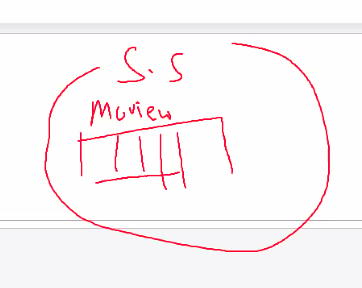
- spark session에 movies라는 테이블이 생긴 것
- RDD에서 filter, join했던 걸 sql query로 하는 것임
- spark.sql(query) 까지 = RDD transformation
- show() = RDD action

In [14]:
# movies 테이블에서 영화 이름(name)만 가져오기
query = '''
        SELECT name 
        FROM movies
'''

# query 실행
spark.sql(query).show()

+--------+
|    name|
+--------+
|어벤져스|
|  슈퍼맨|
|  배트맨|
|겨울왕국|
|아이언맨|
+--------+



In [15]:
# 2010년 이후에 개봉한 영화 조회
query = '''
SELECT * 
FROM movies
WHERE year >= 2010'''

spark.sql(query).show()

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  1|어벤져스|   마블|2012|    4| 26|
|  2|  슈퍼맨|     DC|2013|    6| 13|
|  4|겨울왕국| 디즈니|2014|    1| 16|
+---+--------+-------+----+-----+---+



In [16]:
movies

[(1, '어벤져스', '마블', 2012, 4, 26),
 (2, '슈퍼맨', 'DC', 2013, 6, 13),
 (3, '배트맨', 'DC', 2008, 8, 6),
 (4, '겨울왕국', '디즈니', 2014, 1, 16),
 (5, '아이언맨', '마블', 2008, 4, 30)]

In [17]:
# 제목이 ~~ 맨으로 끝나는 영화 정보 조회
query = '''
SELECT * 
FROM movies
WHERE name LIKE "%맨"'''

spark.sql(query).show()

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  2|  슈퍼맨|     DC|2013|    6| 13|
|  3|  배트맨|     DC|2008|    8|  6|
|  5|아이언맨|   마블|2008|    4| 30|
+---+--------+-------+----+-----+---+



In [18]:
# 개봉 월이 4 -8월 사이인 영화
query = '''
SELECT * 
FROM movies
WHERE month BETWEEN 4 AND 8'''

spark.sql(query).show()


+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  1|어벤져스|   마블|2012|    4| 26|
|  2|  슈퍼맨|     DC|2013|    6| 13|
|  3|  배트맨|     DC|2008|    8|  6|
|  5|아이언맨|   마블|2008|    4| 30|
+---+--------+-------+----+-----+---+



In [19]:
# 회사 이름이 '마'로 시작하거나, '나'로 끝나는 영화 중 2010년 이후로 개봉한 영화
query = """
SELECT *
FROM movies
WHERE (company LIKE '마%' OR company LIKE '%니')
AND year >= 2010
"""

spark.sql(query).show()

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  1|어벤져스|   마블|2012|    4| 26|
|  4|겨울왕국| 디즈니|2014|    1| 16|
+---+--------+-------+----+-----+---+



In [20]:
# 개봉년도 오름차순 정렬
query ="""
SELECT *
FROM movies
ORDER BY year ASC
"""

spark.sql(query).show()

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  3|  배트맨|     DC|2008|    8|  6|
|  5|아이언맨|   마블|2008|    4| 30|
|  1|어벤져스|   마블|2012|    4| 26|
|  2|  슈퍼맨|     DC|2013|    6| 13|
|  4|겨울왕국| 디즈니|2014|    1| 16|
+---+--------+-------+----+-----+---+



In [21]:
# 회사 별 몇 개의 영화가 있는지 조회. 별칭 alias 적용
query ="""
SELECT company, count(*) as movie_cnt
FROM movies
GROUP BY company
"""

spark.sql(query).show()

+-------+---------+
|company|movie_cnt|
+-------+---------+
| 디즈니|        1|
|   마블|        2|
|     DC|        2|
+-------+---------+



**Join**

In [22]:
attendances = [
    (1, 13934592., "KR"),
    (2, 2182227.,"KR"),
    (3, 4226242., "KR"),
    (4, 10303058., "KR"),
    (5, 4300365., "KR")
]

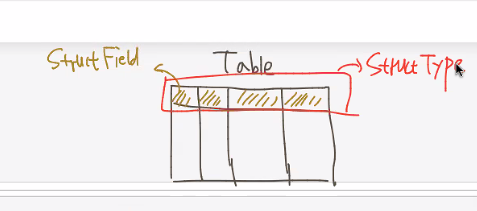

테이블 만들기 전에 먼저 스키마 지정

In [23]:
# 직접 스키마 지정하기

# 1) 데이터 타입 관련 import
from pyspark.sql.types import StringType, FloatType, IntegerType


# 2) 구조 관련 import
    # StructField: 각 컬럼을 만들기 위한 집합 (컬럼 스키마) (이름, type,...)
    # StructType: 컬럼 집합
from pyspark.sql.types import StructType, StructField

In [24]:
# 스키마 만들기
att_schema = StructType([
    StructField('id',IntegerType(), True), # True: Null 허용
    StructField('att', FloatType(), True),
    StructField('country', StringType(), True)
])



In [25]:
# df 만들기
att_df = spark.createDataFrame(
    data = attendances,
    schema = att_schema
)

att_df.dtypes

[('id', 'int'), ('att', 'float'), ('country', 'string')]

In [26]:
att_df.createOrReplaceTempView('att')

In [27]:
att_df.show()

+---+-----------+-------+
| id|        att|country|
+---+-----------+-------+
|  1|1.3934592E7|     KR|
|  2|  2182227.0|     KR|
|  3|  4226242.0|     KR|
|  4|1.0303058E7|     KR|
|  5|  4300365.0|     KR|
+---+-----------+-------+



In [28]:
# 영화 아이디, 영화 이름, 회사, 관객수 조회

query ="""
SELECT movies.id,movies.name, movies.company, att.att
FROM movies
JOIN att ON movies.id = att.id
"""

spark.sql(query).show()


+---+--------+-------+-----------+
| id|    name|company|        att|
+---+--------+-------+-----------+
|  1|어벤져스|   마블|1.3934592E7|
|  2|  슈퍼맨|     DC|  2182227.0|
|  3|  배트맨|     DC|  4226242.0|
|  4|겨울왕국| 디즈니|1.0303058E7|
|  5|아이언맨|   마블|  4300365.0|
+---+--------+-------+-----------+



## 데이터프레임 API

In [29]:
# collect를 사용하면 RDD처럼 등장
df.select('*').collect()

[Row(id=1, name='어벤져스', company='마블', year=2012, month=4, day=26),
 Row(id=2, name='슈퍼맨', company='DC', year=2013, month=6, day=13),
 Row(id=3, name='배트맨', company='DC', year=2008, month=8, day=6),
 Row(id=4, name='겨울왕국', company='디즈니', year=2014, month=1, day=16),
 Row(id=5, name='아이언맨', company='마블', year=2008, month=4, day=30)]

In [30]:
df.select('name','company').collect()

[Row(name='어벤져스', company='마블'),
 Row(name='슈퍼맨', company='DC'),
 Row(name='배트맨', company='DC'),
 Row(name='겨울왕국', company='디즈니'),
 Row(name='아이언맨', company='마블')]

In [31]:
df.select(df.name, (df.year-2000).alias("year")).show()

+--------+----+
|    name|year|
+--------+----+
|어벤져스|  12|
|  슈퍼맨|  13|
|  배트맨|   8|
|겨울왕국|  14|
|아이언맨|   8|
+--------+----+



In [32]:
# agg: Aggregation의 약자. 그룹핑 후 데이터를 하나로 합쳐주는 역할
df.agg({'id':'count'}).collect()

[Row(count(id)=5)]

In [33]:
# query에서 사용가능한 함수들을 모아놓은 패키지가 존재
from pyspark.sql import functions as F

df.agg(F.min(df.year))

DataFrame[min(year): bigint]

In [34]:
# groupBy
df.groupBy().avg().collect() # 컬럼명이 부여되지 않으면각 컬럼별로 집계를 수행한다.

[Row(avg(id)=3.0, avg(year)=2011.0, avg(month)=4.6, avg(day)=18.2)]

In [35]:
# 회사별, 월별 영화 개수 정보
df.groupBy([df.company, df.month]).count().collect()

[Row(company='디즈니', month=1, count=1),
 Row(company='DC', month=8, count=1),
 Row(company='DC', month=6, count=1),
 Row(company='마블', month=4, count=2)]

In [36]:
# 회사 별 개봉 월의 평균
df.groupBy('company').agg({'month':'mean'}).collect()


[Row(company='디즈니', avg(month)=1.0),
 Row(company='마블', avg(month)=4.0),
 Row(company='DC', avg(month)=7.0)]

In [37]:
# join
df.join(att_df, 'id').select(df.name, att_df.att).show()

+--------+-----------+
|    name|        att|
+--------+-----------+
|어벤져스|1.3934592E7|
|  슈퍼맨|  2182227.0|
|  배트맨|  4226242.0|
|겨울왕국|1.0303058E7|
|아이언맨|  4300365.0|
+--------+-----------+



In [38]:
# select, where, orderBy 사용
df.select('name','company','year').where('company=="마블"').orderBy('id').show()

+--------+-------+----+
|    name|company|year|
+--------+-------+----+
|어벤져스|   마블|2012|
|아이언맨|   마블|2008|
+--------+-------+----+



In [39]:
spark.stop()
sc.stop()